In [82]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os
import tikzplotlib

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Parameter Tuning for Diffuser Problem

In [83]:
output_path = './'

In [84]:
textwidth_in_inches = 500.484/72.27

## Computational Mesh

In [85]:
# Create Meshes for Diffuser Problem
n_elem_for_width = 32
n_elem_for_height = 32

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model
### Boundary Conditions

In [86]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [87]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [88]:
viscosity = 1.0
density = 1.0

### Finite Element Model

In [89]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon=8.e-2)
fem.set_boudary_values_v(boundary_values_v)

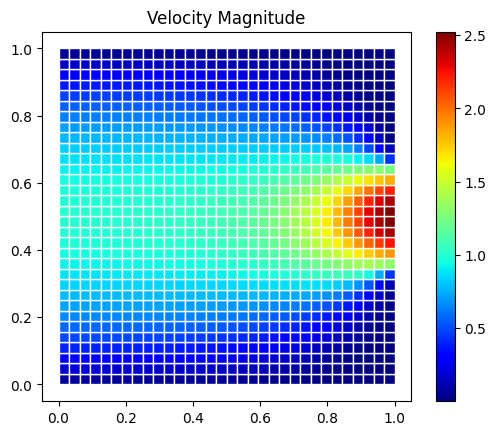

In [90]:
U, u_e, v_e, p_e, F, f = fem.solve()
fem.plot_velocity_magnitude([u_e, v_e])

## Optimization

In [91]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
level_set_scaled_initial = np.ones(mesh_v.n_elem) # Initial scaled level-set function, i.e., design variable, for each element.

In [92]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True

if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')
    
annealing_solver = AnnealingSolver(client)

In [93]:
# Topology Optimization Problem
n_qubits_per_variable = 9
hyperparameters = {
    'energy_dissipation': 100.,
    'regularization': 1.,
    'volume_constraint': 20.,
    'char_func': 0.5,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

In [94]:
# Annealing-Based Optimizer (Two-Step Optimization)
annealing_optimizer = Annealing(fem)
max_opt_steps = 10

## CHAR. FUNC. 0.5 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 9
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.011874273520424654, Volume Fraction: 0.501953125, Inconsistencies: 20
Abs. change in
	char. func.:46.0
Rel. change in
	char. func.:0.08745247148288973
	Obj. func.: 0.5278058316252641
Iteration: 2, Objective Function: 0.010925724589785153, Volume Fraction: 0.5009765625, Inconsistencies: 4
Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.07988269168702619
Iteration: 3, Objective Function: 0.010330040730030965, Volume Fraction: 0.5009765625, Inconsistencies: 9
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.05452122235545948
Iteration: 4, Objective Function: 0.010192187636571606, Volume Fraction: 0.5009765625, Inconsistencies: 20
Ab

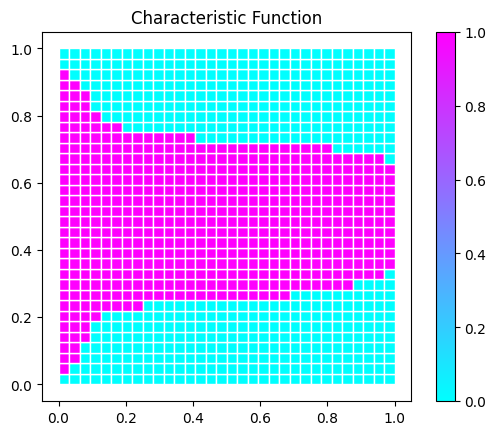

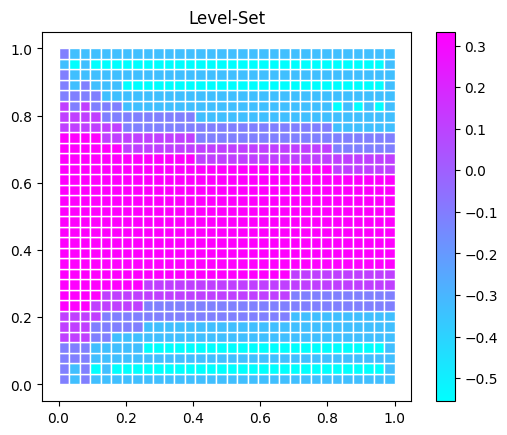

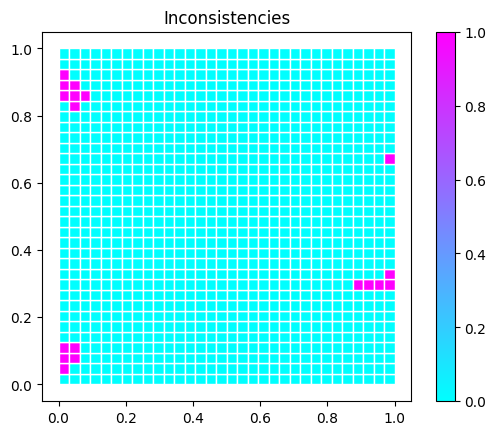

## CHAR. FUNC. 1.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 2
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.01173863854273131, Volume Fraction: 0.501953125, Inconsistencies: 9
Abs. change in
	char. func.:48.0
Rel. change in
	char. func.:0.09125475285171103
	Obj. func.: 0.5331995127952548
Iteration: 2, Objective Function: 0.010860532721602268, Volume Fraction: 0.5009765625, Inconsistencies: 8
Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.07480474144702023
Iteration: 3, Objective Function: 0.010274090776038861, Volume Fraction: 0.5009765625, Inconsistencies: 8
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.053997530378683725
Iteration: 4, Objective Function: 0.010174938510880709, Volume Fraction: 0.5009765625, Inconsistencies: 10
Abs

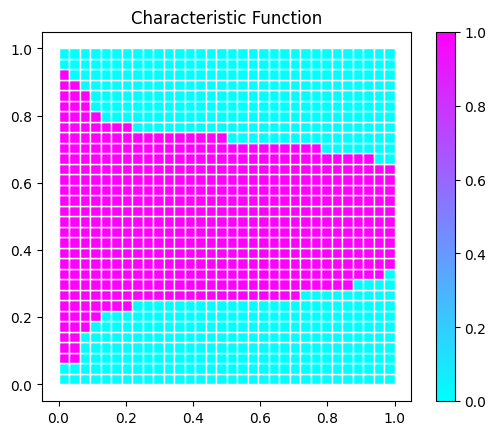

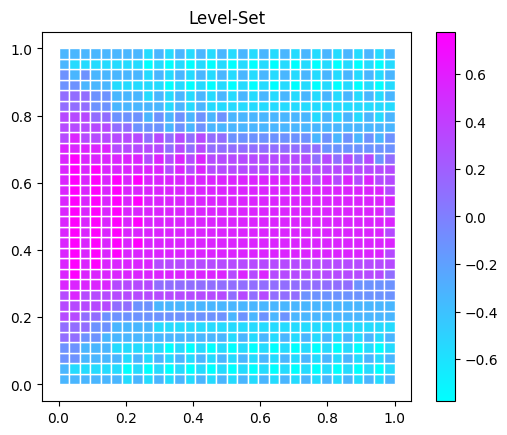

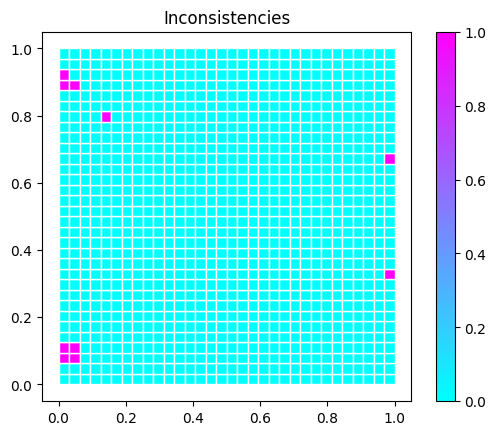

## CHAR. FUNC. 1.5 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 3
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012317136922889146, Volume Fraction: 0.501953125, Inconsistencies: 9
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5101948581479705
Iteration: 2, Objective Function: 0.011025080586721971, Volume Fraction: 0.5009765625, Inconsistencies: 8
Abs. change in
	char. func.:11.0
Rel. change in
	char. func.:0.021400778210116732
	Obj. func.: 0.10489908038337424
Iteration: 3, Objective Function: 0.010370395255121706, Volume Fraction: 0.5009765625, Inconsistencies: 7
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.0593814554415805
Iteration: 4, Objective Function: 0.010055340022179957, Volume Fraction: 0.5009765625, Inconsistencies: 7
Abs.

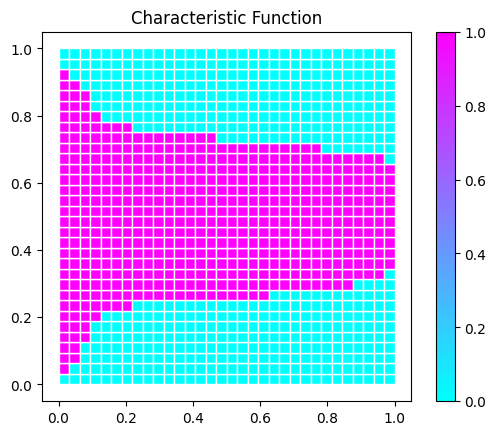

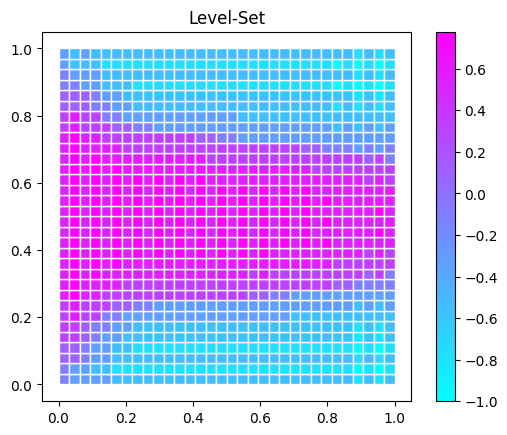

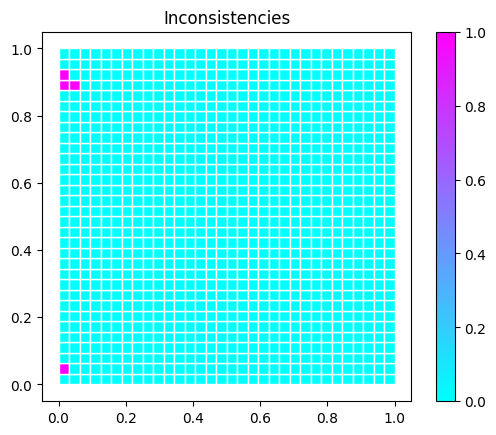

## CHAR. FUNC. 2.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012175104457726746, Volume Fraction: 0.501953125, Inconsistencies: 4
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5158429427785135
Iteration: 2, Objective Function: 0.011302843271245077, Volume Fraction: 0.5009765625, Inconsistencies: 5
Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.07164301460494675
Iteration: 3, Objective Function: 0.010497924862822115, Volume Fraction: 0.5009765625, Inconsistencies: 4
Abs. change in
	char. func.:8.0
Rel. change in
	char. func.:0.015594541910331383
	Obj. func.: 0.07121379896248844
Iteration: 4, Objective Function: 0.010079801222774042, Volume Fraction: 0.5009765625, Inconsistencies: 3
Abs.

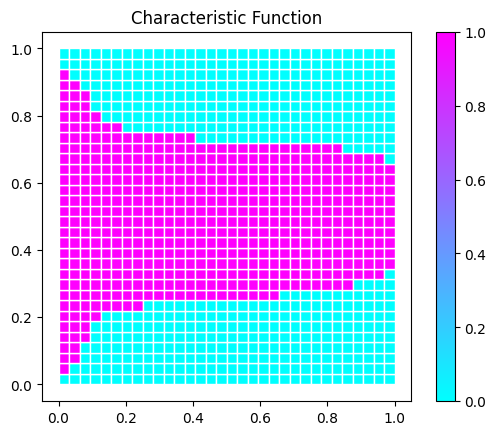

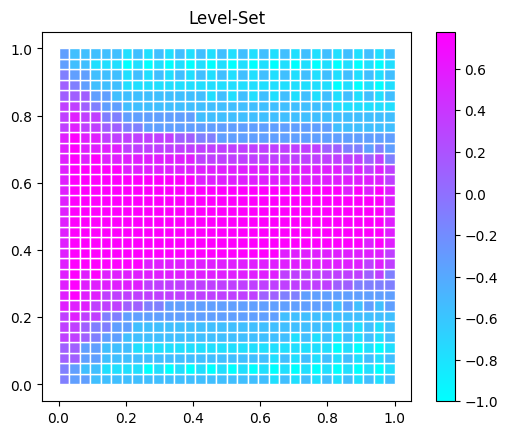

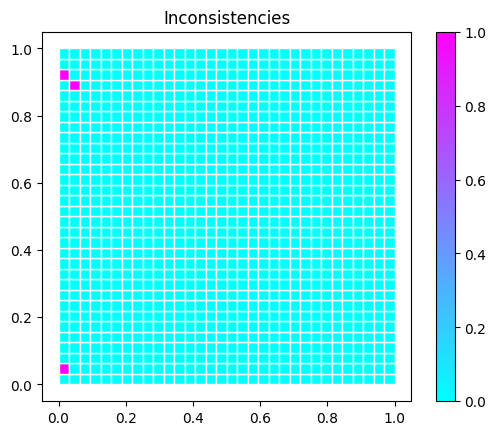

## CHAR. FUNC. 2.5 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 2
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.011849424650870313, Volume Fraction: 0.501953125, Inconsistencies: 2
Abs. change in
	char. func.:46.0
Rel. change in
	char. func.:0.08745247148288973
	Obj. func.: 0.5287939755545816
Iteration: 2, Objective Function: 0.01061567592200387, Volume Fraction: 0.5009765625, Inconsistencies: 3
Abs. change in
	char. func.:13.0
Rel. change in
	char. func.:0.02529182879377432
	Obj. func.: 0.10411887203112656
Iteration: 3, Objective Function: 0.010200750196726987, Volume Fraction: 0.5009765625, Inconsistencies: 1
Abs. change in
	char. func.:4.0
Rel. change in
	char. func.:0.007797270955165692
	Obj. func.: 0.03908613340548928
Iteration: 4, Objective Function: 0.010102071419501434, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. 

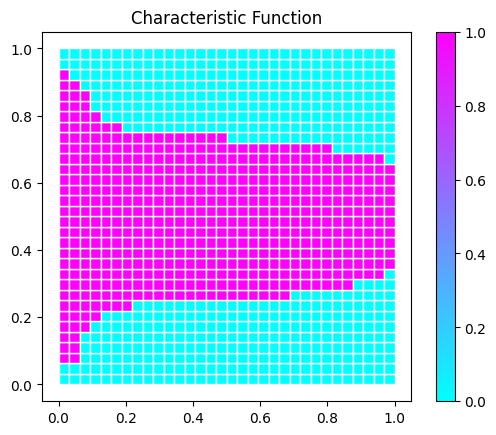

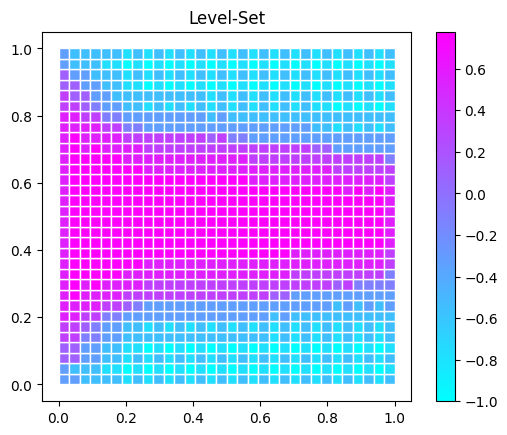

## CHAR. FUNC. 3.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.011619875596583727, Volume Fraction: 0.501953125, Inconsistencies: 1
Abs. change in
	char. func.:48.0
Rel. change in
	char. func.:0.09125475285171103
	Obj. func.: 0.5379222581904515
Iteration: 2, Objective Function: 0.010742674081189257, Volume Fraction: 0.5009765625, Inconsistencies: 3
Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.07549147218515566
Iteration: 3, Objective Function: 0.010375121528523507, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:4.0
Rel. change in
	char. func.:0.007797270955165692
	Obj. func.: 0.03421425148784376
Iteration: 4, Objective Function: 0.010068464584296687, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs.

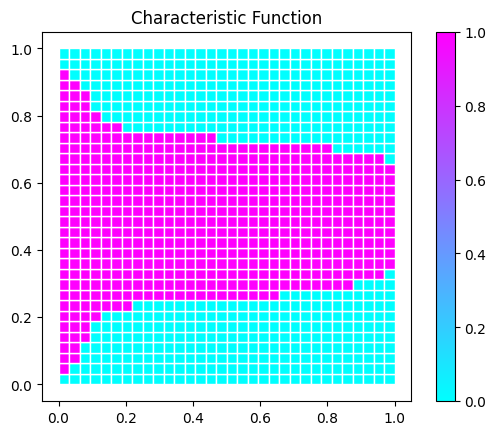

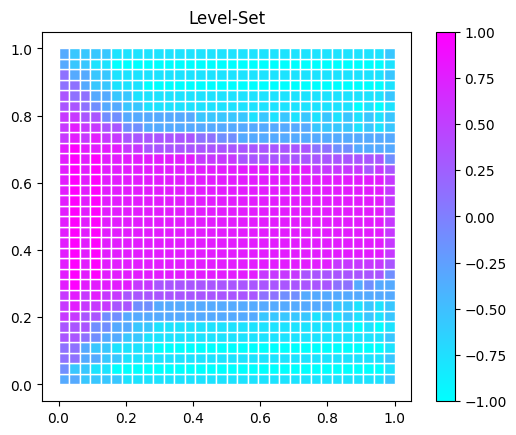

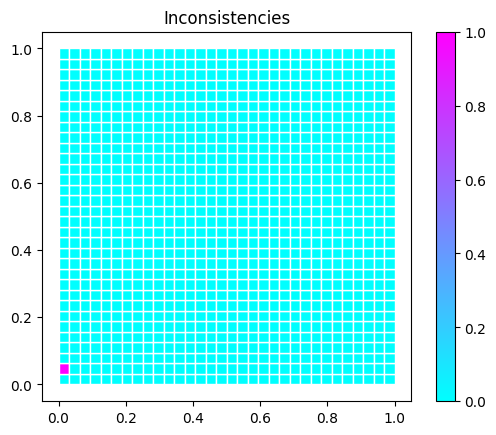

## CHAR. FUNC. 3.5 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012198826667617532, Volume Fraction: 0.501953125, Inconsistencies: 2
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5148996017688826
Iteration: 2, Objective Function: 0.010773610431915374, Volume Fraction: 0.5009765625, Inconsistencies: 3
Abs. change in
	char. func.:13.0
Rel. change in
	char. func.:0.02529182879377432
	Obj. func.: 0.11683223924194887
Iteration: 3, Objective Function: 0.010298272510390713, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.04412057819693727
Iteration: 4, Objective Function: 0.010161840877591637, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs.

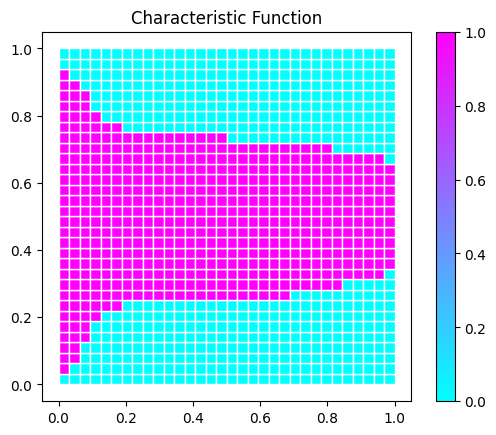

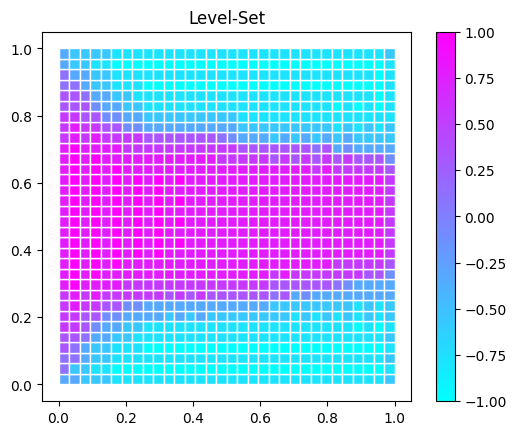

## CHAR. FUNC. 4.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012316348663074028, Volume Fraction: 0.501953125, Inconsistencies: 0
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5102262042077714
Iteration: 2, Objective Function: 0.010855722984206357, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:13.0
Rel. change in
	char. func.:0.02529182879377432
	Obj. func.: 0.11859242692981006
Iteration: 3, Objective Function: 0.010289910877971868, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.052121089222493124
Iteration: 4, Objective Function: 0.010115607835833753, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs

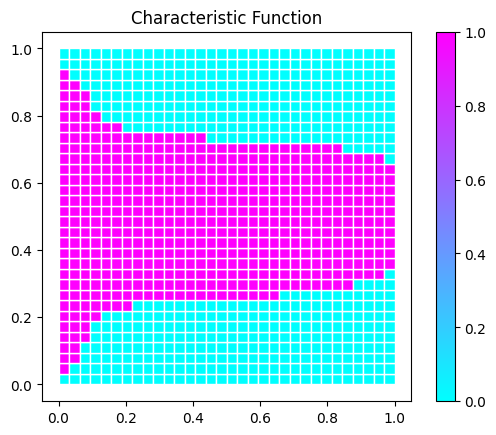

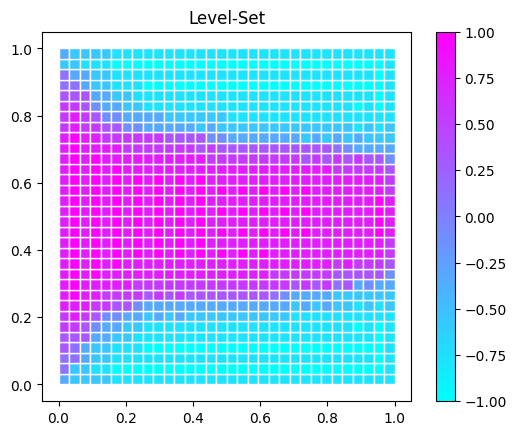

## CHAR. FUNC. 4.5 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.011995516157709166, Volume Fraction: 0.501953125, Inconsistencies: 0
Abs. change in
	char. func.:46.0
Rel. change in
	char. func.:0.08745247148288973
	Obj. func.: 0.5229844784548452
Iteration: 2, Objective Function: 0.010740931695337784, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:11.0
Rel. change in
	char. func.:0.021400778210116732
	Obj. func.: 0.10458778479199475
Iteration: 3, Objective Function: 0.010204767422872709, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.04991785514265983
Iteration: 4, Objective Function: 0.010106977342712212, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs

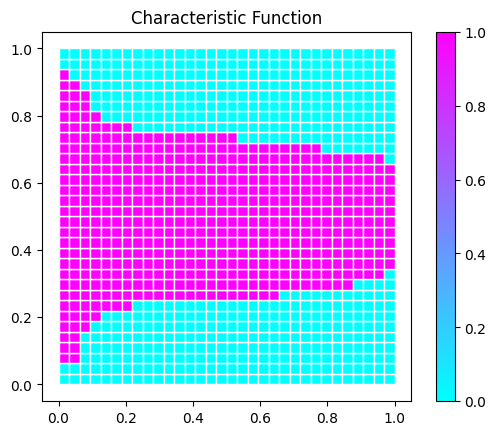

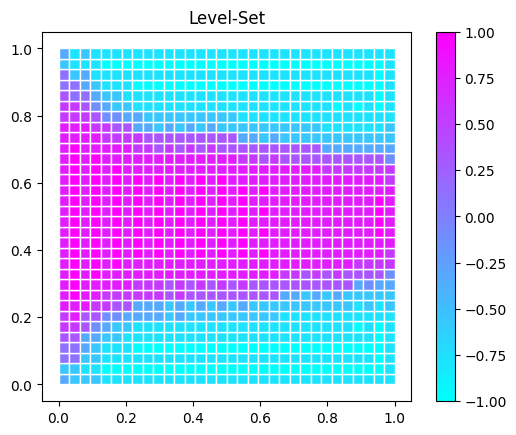

## CHAR. FUNC. 5.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.011974189738367152, Volume Fraction: 0.501953125, Inconsistencies: 0
Abs. change in
	char. func.:46.0
Rel. change in
	char. func.:0.08745247148288973
	Obj. func.: 0.5238325480928143
Iteration: 2, Objective Function: 0.010956385106752826, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.08499987505234885
Iteration: 3, Objective Function: 0.01042106758847021, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.04885895421407567
Iteration: 4, Objective Function: 0.010129262330434778, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. 

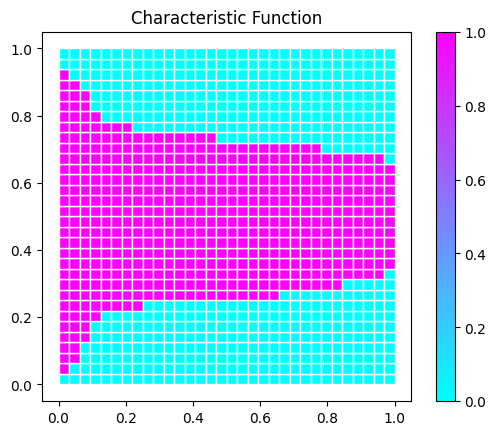

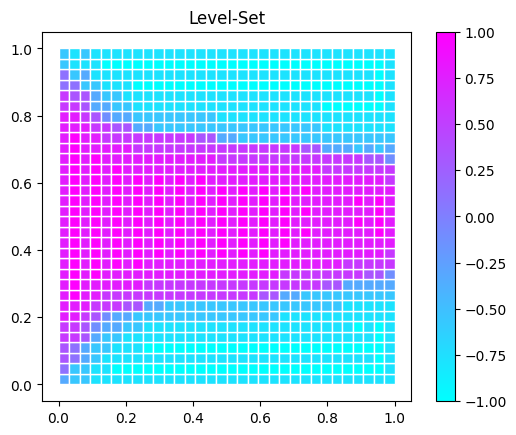

In [95]:
# Hyperparameter Study.

lambda_char_initial = 0.5
lambda_char_delta = 0.5
n_steps_char = 10
lambda_char_values = []


objective_functions_values = []
volume_fraction_values = []
inconsistency_values = []
char_funcs = []
level_sets = []

for lambda_char_i in range(n_steps_char):
    hyperparameters['char_func'] = lambda_char_initial + lambda_char_i * lambda_char_delta
    lambda_char_values.append(hyperparameters['char_func'])
    print(f"## CHAR. FUNC. {lambda_char_values[-1]} ##")

    topo_opt_problem.set_hyperparameters(hyperparameters)
    annealing_optimizer.optimize(annealing_solver, 
                                topo_opt_problem,
                                level_set_scaled_initial, 
                                max_opt_steps, tol=1e-2)
    objective_functions_values.append(annealing_optimizer.objective_function)
    volume_fraction_values.append(annealing_optimizer.volume_fraction)
    inconsistency_values.append(annealing_optimizer.n_inconsistencies)
    level_set, level_set_scaled, char_func = topo_opt_problem.get_functions_from_binary_solutions(annealing_optimizer.binary_solutions_optimum)
    char_funcs.append(char_func)
    level_sets.append(level_sets)



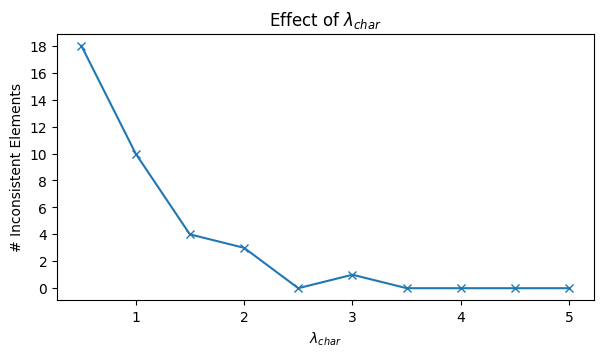

In [119]:
aspect_ratio = 0.5
fig, ax = plt.subplots(1, 1, figsize=(textwidth_in_inches, textwidth_in_inches * aspect_ratio))
ax.plot(lambda_char_values, inconsistency_values, marker='x')
ax.set_title(r'Effect of $\lambda_{char}$')
ax.set_xlabel(r'$\lambda_{char}$')
ax.set_ylabel('# Inconsistent Elements')
# ax.set_ylim([-0.5,18.5])
ax.set_yticks(np.arange(0,19,2))
fig.show()

tikzplotlib.save(os.path.join(output_path, 'inconsistencies.tex'))